In [68]:
import pandas as pd
from fcmeans import FCM
import numpy as np
from sklearn.cluster import KMeans
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook 

import tensorflow
from tensorflow.keras.layers import LSTM,Embedding
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from xgboost import XGBRegressor
import time
from sklearn import metrics

In [61]:
def normalize(train):
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm

In [62]:
def buildTrain(train, pastDay=10, futureDay=5):
    X_train, y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]).reshape(-1))
        y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["people"]))
    return np.array(X_train), np.array(y_train)

In [63]:
def denormalize2(test):
    denorm = test.apply(lambda x: x*(np.max(df_test['people'])-np.min(df_test['people']))+np.mean(df_test['people']))
    return denorm


In [3]:
etc_df = pd.read_csv('data.csv')

In [4]:
etc_df.columns

Index(['datacollecttime', 'volume'], dtype='object')

In [5]:
etc_df['datacollecttime'] = pd.to_datetime(etc_df['datacollecttime'])
etc_df['Date'] = etc_df['datacollecttime'].dt.strftime('%Y-%m-%d')
etc_df['Month'] = etc_df['datacollecttime'].dt.strftime('%m')
etc_df['Time'] = etc_df['datacollecttime'].dt.strftime('%H')


In [6]:
sortetc= etc_df.groupby(['Date','Month','Time'])['volume'].agg('sum')
sortetc = pd.DataFrame(sortetc)
sortetc = sortetc.reset_index()

In [7]:
sortetc['Week']=""
for i in range(0,len(sortetc)):
    sortetc['Week'].iloc[i] = pd.Timestamp(sortetc['Date'].iloc[i]).isoweekday()

/Users/julia/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
for i in sortetc.Date.unique().tolist():
    if len(sortetc[sortetc['Date']==i])!=24:
        losthour=[]
        for y in sortetc.Time.unique().tolist():
            if y not in sortetc[sortetc['Date']==i]['Time'].tolist():
                losthour.append(y)
        for r in losthour:
            new =pd.DataFrame({'Date':i,
                    'Month':pd.Timestamp(i).strftime('%m'),
                  'Time':r,
                    'Week':pd.Timestamp(i).isoweekday(),
                  'volume':None},index=[1])
            sortetc=sortetc.append(new)

In [9]:
sortetc = sortetc.sort_values(by=['Date', 'Time'], ascending=True)
sortetc = sortetc.reset_index(drop=True)

In [10]:
df_null = sortetc[sortetc['volume'].isnull().values==True]

In [11]:
for i in range(0,len(df_null)):
    df = sortetc[sortetc['Month']==pd.Timestamp(df_null.iloc[[i]]['Date'].tolist()[0]).strftime('%m')]
    #null_df = df[df['volume'].isnull().values==True]
    nonull_df = df[df['volume'].isnull().values==False]
    week_df = nonull_df[nonull_df['Week']== df_null.iloc[[i]]['Week'].tolist()[0]]
    df_null['volume'].iloc[i]=int(week_df[week_df['Time']==df_null.iloc[[i]]['Time'].tolist()[0]]['volume'].mean())

In [12]:
df_nonull = sortetc[sortetc['volume'].isnull().values==False]

In [13]:
etc_new = pd.concat([df_nonull,df_null])
etc_new = etc_new.sort_values(by=['Date', 'Time'], ascending=True)
etc_new = etc_new.reset_index(drop=True)

In [14]:
etc_df=pd.DataFrame()
for i in etc_new.Date.unique().tolist():
    tem = etc_new[etc_new['Date']==i]
    mon = etc_new[etc_new['Month']==pd.Timestamp(i).strftime('%m')]
    tem['percent'] = tem['volume']/mon['volume'].sum()
    etc_df = pd.concat([etc_df,tem])

<ipython-input-14-68037e9359e3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tem['percent'] = tem['volume']/mon['volume'].sum()


In [15]:
peo = pd.read_csv('/Users/julia/Desktop/科技部大專生計畫/宜蘭景點/景點篩選.csv')

In [16]:
monlist = ['01','02','03','04','05','06','07','08','09','10','11','12']

In [17]:
peo['月']= pd.DataFrame(monlist)

In [18]:
peo

,Unnamed: 0,年,月,梅花湖,傳統藝術中心,冬山河親水公園,蘭陽博物館,清水地熱,太平山森林遊樂區,龍潭湖,五峰旗,大里外澳遊憩區
0,0,109,01,66479,131157,19169,53631,106431,35935,36669,43524,139478
1,1,109,02,63401,79921,12751,44911,130084,40955,27393,38976,97702
2,2,109,03,37399,37228,8694,21305,78197,20117,19207,44815,62011
3,3,109,04,30861,30947,9103,18533,39496,20639,18350,34855,49810
4,4,109,05,30000,49353,9417,32651,40773,23343,15692,51795,49868
5,5,109,06,37590,79728,12655,61497,64622,43761,23093,88399,153632
6,6,109,07,42845,108068,108179,96741,75798,70687,24549,111145,185877
7,7,109,08,50678,130311,119337,94723,97044,91646,222974,115102,168998
8,8,109,09,48281,73662,9228,49811,66101,50013,25006,98215,139611
9,9,109,10,63755,101487,19329,72345,98159,78608,40518,92627,148363


In [19]:
don = peo[['月','五峰旗']]

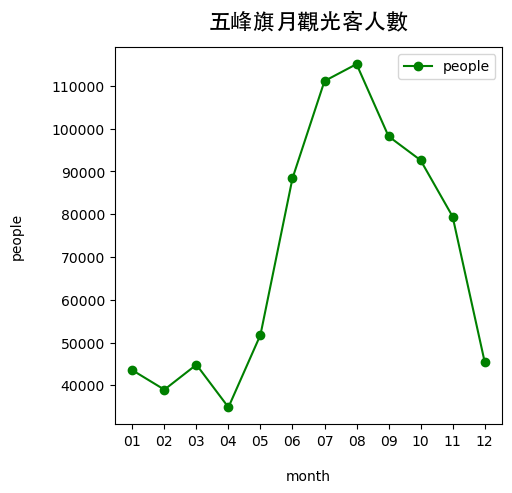

In [280]:
plt.figure(figsize=(5,5),dpi=100,linewidth = 2)
from matplotlib.font_manager import FontProperties


myFont = FontProperties(fname='/System/Library/Fonts/STHeiti Medium.ttc', size=16) 
## fname='找出你的電腦中儲存中文字體的路徑' ##
plt.plot(don['月'],don['五峰旗'],'o-',color = 'g', label="people")



# 設定圖片標題，以及指定字型設定，x代表與圖案最左側的距離，y代表與圖片的距離

plt.title("五峰旗月觀光客人數",fontproperties=myFont, x=0.5, y=1.03)

# 设置刻度字体大小

plt.xticks(fontsize=10)

plt.yticks(fontsize=10)

# 標示x軸(labelpad代表與圖片的距離)

plt.xlabel("month", fontsize=10, labelpad = 15)

# 標示y軸(labelpad代表與圖片的距離)

plt.ylabel("people", fontsize=10, labelpad = 20)

# 顯示出線條標記位置

plt.legend(loc = "best", fontsize=10)

# 畫出圖片

plt.show()

In [20]:
etc_df['people']=""
for i in range(0,len(etc_df)):
    Peo = don[don['月']==etc_df['Month'].iloc[i]]['五峰旗'].tolist()[0]
    etc_df['people'].iloc[i] = Peo*etc_df['percent'].iloc[i]

In [21]:
etc_df

,Date,Month,Time,volume,Week,percent,people
0,2020-01-01,01,00,20534,3,0.000446,19.414479
1,2020-01-01,01,01,24691,3,0.000536,23.344838
2,2020-01-01,01,02,17685,3,0.000384,16.720807
3,2020-01-01,01,03,14873,3,0.000323,14.062119
4,2020-01-01,01,04,13439,3,0.000292,12.706301
...,...,...,...,...,...,...,...
8779,2020-12-31,12,19,62847,4,0.001399,63.68759
8780,2020-12-31,12,20,54437,4,0.001212,55.165105
8781,2020-12-31,12,21,44818,4,0.000998,45.417449
8782,2020-12-31,12,22,34856,4,0.000776,35.322205


In [22]:
gotr_1 = pd.read_csv('/Users/julia/Desktop/科技部大專生計畫/GoogleTrend爬蟲/gt_五峰旗.csv')

In [23]:
gotr_2 = pd.read_csv('/Users/julia/Desktop/科技部大專生計畫/GoogleTrend爬蟲/gt_五峰旗瀑布.csv')

In [24]:
gotr_1['date'] = pd.to_datetime(gotr_1['date'])
gotr_1['Date'] = gotr_1['date'].dt.strftime('%Y-%m-%d')
gotr_1['Time'] = gotr_1['date'].dt.strftime('%H')
gotr_1['Month']  = gotr_1['date'].dt.strftime('%m')

In [25]:
gotr_2['date'] = pd.to_datetime(gotr_2['date'])
gotr_2['Date'] = gotr_2['date'].dt.strftime('%Y-%m-%d')
gotr_2['Time'] = gotr_2['date'].dt.strftime('%H')
gotr_2['Month']  = gotr_2['date'].dt.strftime('%m')

In [26]:
gotr_1 = gotr_1[['Date','Month','Time','五峰旗']]

In [27]:
gotr_2 = gotr_2[['Date','Month','Time','五峰旗瀑布']]

In [28]:
gotr_2 = gotr_2.rename(columns={'五峰旗瀑布': '五峰旗'})

In [29]:
gotr_1 = pd.concat([gotr_1,gotr_2])

In [30]:
gotr_1 = gotr_1.groupby(['Date','Time','Month']).sum()

In [31]:
gotr_1 = gotr_1.reset_index()

In [32]:
gotr_1= gotr_1.sort_values(by=['Date', 'Time'], ascending=True)
gotr_1= gotr_1.reset_index(drop=True)

In [33]:
for i in etc_df.Date.unique().tolist() :
    if i not in gotr_1.Date.unique().tolist():
        for j in etc_df[etc_df['Date']==i].Time.tolist():
            new =pd.DataFrame({'Date':i,
                        'Time':j,
                    'Month':pd.Timestamp(i).strftime('%m'),
                    '五峰旗':0,
                  },index=[1])
            gotr_1=gotr_1.append(new)

In [34]:
gotr_1 = gotr_1.reset_index(drop=True)

In [37]:
wea = pd.read_csv('/Users/julia/Desktop/科技部大專生計畫/宜蘭天氣資料/2020天氣資料.csv')
wea_1 = wea.loc[wea['測站']=='礁溪'].reset_index(drop=True)  #冬山河親水公園
wea_1=wea_1.drop(['Unnamed: 0'],axis=1)
wea_1['觀測時間'] = wea_1['觀測時間'].replace(wea_1['觀測時間'].unique().tolist(),gotr_1['Time'].unique().tolist())

In [38]:
wea_1 = wea_1[['測站','測站氣壓','氣溫','相對溼度','風速','降水量']]

In [39]:
wea_1.dtypes

測站       object
測站氣壓    float64
氣溫      float64
相對溼度    float64
風速      float64
降水量     float64
dtype: object

In [40]:
all_df = pd.concat([etc_df,gotr_1['五峰旗'],wea_1],axis=1)

In [41]:
hashtag = pd.read_csv('/Users/julia/Desktop/科技部大專生計畫/IG資料爬蟲/五峰旗hashtag.csv')
hashtag2 = pd.read_csv('/Users/julia/Desktop/科技部大專生計畫/IG資料爬蟲/五峰旗瀑布hashtag.csv')

In [42]:
hashtag = hashtag.drop(['Unnamed: 0'],axis=1)
hashtag2 = hashtag2.drop(['Unnamed: 0'],axis=1)

In [43]:
hashtag['Date'] = pd.to_datetime(hashtag['Date'],errors='coerce')
hashtag['Time'] = pd.to_datetime(hashtag['Time'],errors='coerce') 

hashtag2['Date'] = pd.to_datetime(hashtag2['Date'],errors='coerce')
hashtag2['Time'] = pd.to_datetime(hashtag2['Time'],errors='coerce') 

In [44]:
hashtag['date'] = hashtag['Date'].dt.strftime('%Y-%m-%d')
hashtag['Month'] = hashtag['Date'].dt.strftime('%m')
hashtag['Hour'] = hashtag['Time'].dt.strftime('%H')


hashtag2['date'] = hashtag2['Date'].dt.strftime('%Y-%m-%d')
hashtag2['Month'] = hashtag2['Date'].dt.strftime('%m')
hashtag2['Hour'] = hashtag2['Time'].dt.strftime('%H')


In [45]:
hashtag=hashtag[['date','Month','Hour','hashtag']]
hashtag= hashtag.groupby(['date','Month','Hour'])['hashtag'].agg('sum')
hashtag= pd.DataFrame(hashtag)
hashtag= hashtag.reset_index()

hashtag2=hashtag2[['date','Month','Hour','hashtag']]
hashtag2= hashtag2.groupby(['date','Month','Hour'])['hashtag'].agg('sum')
hashtag2= pd.DataFrame(hashtag2)
hashtag2= hashtag2.reset_index()

In [46]:
hashtag = pd.concat([hashtag,hashtag2])

In [47]:
hashtag= hashtag.groupby(['date','Month','Hour'])['hashtag'].agg('sum')
hashtag= pd.DataFrame(hashtag)
hashtag= hashtag.reset_index()

In [48]:
hashtag

,date,Month,Hour,hashtag
0,2020-01-01,01,02,1
1,2020-01-01,01,14,2
2,2020-01-01,01,16,1
3,2020-01-02,01,08,1
4,2020-01-04,01,12,1
...,...,...,...,...
1280,2020-12-29,12,15,2
1281,2020-12-30,12,04,1
1282,2020-12-30,12,05,1
1283,2020-12-30,12,06,1


In [49]:
df_don = pd.merge(all_df,hashtag,left_on = ['Date','Time'],right_on=['date','Hour'])

In [273]:
df_don=df_don[['Date', 'Time', 'volume', 'Week', 'percent', 'people',
       '五峰旗', '測站', '測站氣壓', '氣溫', '相對溼度', '風速', '降水量', 'hashtag']]

In [274]:
dfall = pd.merge(all_df,df_don,'outer')

In [275]:
dfall['氣溫'] = dfall['氣溫'].interpolate()
dfall['測站氣壓'] = dfall['測站氣壓'].interpolate()
dfall['相對溼度'] = dfall['相對溼度'].interpolate()

In [276]:
dfall['風速']= dfall['風速'].interpolate()

In [277]:
dfall['hashtag'] = dfall['hashtag'].fillna(0) 

In [278]:
dfall = dfall.reset_index(drop=True)

In [279]:
dfall.to_csv('/Users/julia/Desktop/科技部大專生計畫/2020_五峰旗.csv')

In [247]:
dfall = dfall[['Month', 'Time', 'volume', 'Week',
       '五峰旗', '測站氣壓', '氣溫', '相對溼度', '風速', '降水量', 'hashtag','people']]

In [248]:
df_train = dfall.iloc[:5856,:] #2020/08/31
df_test = dfall.iloc[5856:,:]


In [249]:
df_train = df_train.astype('float64')
df_test = df_test.astype('float64')

In [250]:
df_train

,Month,Time,volume,Week,五峰旗,測站氣壓,氣溫,相對溼度,風速,降水量,hashtag,people
0,1.0,0.0,20534.0,3.0,27.0,1027.8,13.7,99.0,0.3,0.0,0.0,19.414479
1,1.0,1.0,24691.0,3.0,33.0,1027.4,13.8,99.0,0.4,0.0,0.0,23.344838
2,1.0,2.0,17685.0,3.0,81.0,1027.1,13.8,99.0,0.4,0.0,1.0,16.720807
3,1.0,3.0,14873.0,3.0,0.0,1027.1,14.0,99.0,0.0,0.0,0.0,14.062119
4,1.0,4.0,13439.0,3.0,0.0,1027.3,13.8,99.0,0.3,0.0,0.0,12.706301
...,...,...,...,...,...,...,...,...,...,...,...,...
5851,8.0,19.0,76972.0,1.0,0.0,1002.2,28.5,80.0,0.8,0.0,0.0,171.490406
5852,8.0,20.0,67409.0,1.0,0.0,1002.2,26.0,99.0,0.4,1.5,0.0,150.184441
5853,8.0,21.0,49313.0,1.0,44.0,1002.7,25.7,99.0,0.6,2.5,0.0,109.867307
5854,8.0,22.0,34720.0,1.0,42.0,1002.0,27.3,89.0,0.4,0.0,0.0,77.354712


In [134]:
df_train2 = normalize(df_train)
df_test2 = normalize(df_test)

# RandomForestRegressor

In [243]:
dfall2 = dfall
dfall2['pre'] = dfall2['people'].shift(-1)
dfall2 = dfall2.dropna(subset = ['pre']) 
X = dfall2.iloc[:,:-1].values.astype(float)
y = dfall2.iloc[:,-1].values.astype(float)

In [268]:
X_train, y_train = buildTrain(df_train,1,1)
X_test, y_test = buildTrain(df_test,1, 1)

In [244]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [253]:
from sklearn.ensemble import RandomForestRegressor
import time
randomForestModel = RandomForestRegressor(n_estimators=100, criterion = 'mse')
start = time.time()
# 使用訓練資料訓練模型
randomForestModel.fit(X_train, y_train)
# 使用訓練資料預測
predicted=randomForestModel.predict(X_test)
end = time.time()

print(end - start)

<ipython-input-253-85a577cc4849>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  randomForestModel.fit(X_train, y_train)


2.472707748413086


In [254]:
test_y = pd.DataFrame(y_test,columns=['people'])
test_y = test_y.reset_index(drop=True)
predicted = pd.DataFrame(predicted,columns = ['predict'])

In [255]:
g1_test = pd.concat([test_y,predicted], axis = 1)
g1_test = g1_test[g1_test['people']!=0]

In [256]:
def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

# MSE
print("MSE:",metrics.mean_squared_error(test_y, predicted)) 
# RMSE
print("RMSE:",np.sqrt(metrics.mean_squared_error(test_y, predicted))) 
# MAE
print("MAE:",metrics.mean_absolute_error(test_y, predicted)) 

print('MAPE:',mape(np.array(g1_test['people']), np.array(g1_test['predict'])))

print('r2:', r2_score(np.array(g1_test['people']),  np.array(g1_test['predict'])))

MSE: 220.2373325349137
RMSE: 14.840395295776784
MAE: 10.116854883359629
MAPE: 15.119429512200352
r2: 0.9525299266666931


# SVR

In [183]:
X = dfall2.iloc[:,:-1].values.astype(float)
y = dfall2.iloc[:,-1].values.astype(float)

#3 Feature Scaling
from sklearn.preprocessing import StandardScaler
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

sc=StandardScaler()
sc.fit(X_train)
X_train=sc.transform(X_train)
X_test=sc.transform(X_test)


In [257]:
sc=StandardScaler()
sc.fit(X_train)
X_train=sc.transform(X_train)
X_test=sc.transform(X_test)

In [258]:
from sklearn.svm import SVR
start = time.time()
clf  = SVR(kernel='rbf', C=1e3)
clf.fit(X_train, y_train)
end = time.time()
print(end-start)

/Users/julia/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


18.205682039260864


In [259]:
predicted_clf= clf.predict(X_test)

In [260]:
predicted_clf

array([51.01175006, 10.21511192,  4.9264451 , ..., 70.70930311,
       62.76706448, 59.06037075])

In [261]:
test_y = pd.DataFrame(y_test,columns=['people'])

test_y = test_y.reset_index(drop=True)

predicted_clf= pd.DataFrame(predicted_clf,columns = ['predict'])

In [262]:
g1_test = pd.concat([test_y,predicted_clf], axis = 1)
g1_test = g1_test[g1_test['people']!=0]

In [263]:
def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

# MSE
print("MSE:",metrics.mean_squared_error(test_y, predicted_clf)) 
# RMSE
print("RMSE:",np.sqrt(metrics.mean_squared_error(test_y, predicted_clf))) 
# MAE
print("MAE:",metrics.mean_absolute_error(test_y,predicted_clf)) 

print('MAPE:',mape(np.array(g1_test['people']), np.array(g1_test['predict'])))

print('r2:', r2_score(np.array(g1_test['people']),  np.array(g1_test['predict'])))

MSE: 1020.3556150345566
RMSE: 31.9430057294951
MAE: 24.509306637631582
MAPE: 42.308837056214024
r2: 0.7800720008990152


# Linear Regression

In [189]:
from sklearn.linear_model import LinearRegression

In [190]:
X = dfall2.iloc[:,:-1].values.astype(float)
y = dfall2.iloc[:,-1].values.astype(float)

#3 Feature Scaling
from sklearn.preprocessing import StandardScaler
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

sc=StandardScaler()
sc.fit(X_train)
X_train=sc.transform(X_train)
X_test=sc.transform(X_test)


In [264]:
X_train

array([[-1.53095962, -1.66121646, -1.1941671 , ..., -0.14558911,
        -0.3604127 , -1.03320897],
       [-1.53095962, -1.51671564, -1.07991474, ..., -0.14558911,
        -0.3604127 , -0.97590416],
       [-1.53095962, -1.37221481, -1.27246996, ..., -0.14558911,
         1.35491734, -1.07248281],
       ...,
       [ 1.5177168 ,  1.08429926,  0.35699356, ..., -0.14558911,
        -0.3604127 ,  1.18406464],
       [ 1.5177168 ,  1.22880008,  0.0941609 , ...,  1.10043234,
        -0.3604127 ,  0.87342275],
       [ 1.5177168 ,  1.37330091, -0.40319555, ...,  1.93111331,
        -0.3604127 ,  0.28559719]])

In [269]:
LR =LinearRegression()
start = time.time()
# 使用訓練資料訓練模型
LR.fit(X_train, y_train)
# 使用訓練資料預測
predicted_LR= LR.predict(X_test)
end = time.time()

print(end - start)

0.0040090084075927734


In [270]:
test_y = pd.DataFrame(y_test,columns=['people'])

test_y = test_y.reset_index(drop=True)

predicted_LR= pd.DataFrame(predicted_LR,columns = ['predict'])
    
g1_test = pd.concat([test_y,predicted_LR], axis = 1)
g1_test = g1_test[g1_test['people']!=0]

In [271]:
def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

# MSE
print("MSE:",metrics.mean_squared_error(test_y, predicted_LR)) 
# RMSE
print("RMSE:",np.sqrt(metrics.mean_squared_error(test_y, predicted_LR))) 
# MAE
print("MAE:",metrics.mean_absolute_error(test_y, predicted_LR)) 

print('MAPE:',mape(np.array(g1_test['people']), np.array(g1_test['predict'])))

print('r2:', r2_score(np.array(g1_test['people']),  np.array(g1_test['predict'])))

MSE: 543.6788786491248
RMSE: 23.316922581016666
MAE: 16.748340421615424
MAPE: 27.945885671820996
r2: 0.8828151615251123


# XGBoost

In [238]:
xg_df = pd.DataFrame()

In [239]:
def model_triaining_XG(hour,predict_hour):
    global xg_df
    X_train, y_train = buildTrain(df_train,hour,predict_hour)
    X_test, y_test = buildTrain(df_test, hour, predict_hour)
   
    xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, min_child_weight=5, max_depth=4)
    start = time.time()
    model = xgb.fit(X_train,y_train)
    end = time.time()
    timespend = end-start
    
    y_pred_xg = model.predict(X_test)

    
    test_y = pd.DataFrame(y_test,columns=['true'])
    test_y = test_y.reset_index(drop=True)

    test_predict = pd.DataFrame(y_pred_xg,columns=['predict'])
    
    g1_test = pd.concat([test_y,test_predict], axis = 1)
    g1_test = g1_test[g1_test['true']!=0]
    

    MSE = metrics.mean_squared_error(test_y, test_predict)
    RMSE = np.sqrt(metrics.mean_squared_error(test_y,test_predict ))
    MAE = metrics.mean_absolute_error(test_y,test_predict)
    MAPE = mape(np.array(g1_test['true']), np.array(g1_test['predict']))
    R2 = r2_score(np.array(g1_test['true']),  np.array(g1_test['predict']))
    

    XG_dataframe = pd.DataFrame({'MSE':MSE,
                            'RMSE':RMSE,
                            'MAE':MAE,
                            'MAPE':MAPE,
                            'R2':R2,
                            'Time':timespend},index=[1])
    xg_df = pd.concat([xg_df,XG_dataframe])
    return xg_df

In [240]:
for i in range(1,13):
    print(i)
    hour = i
    predict_hour=1
    xg_dataframe = model_triaining_XG(hour,predict_hour)
    print('------------------------')

1
------------------------
2
------------------------
3
------------------------
4
------------------------
5
------------------------
6
------------------------
7
------------------------
8
------------------------
9
------------------------
10
------------------------
11
------------------------
12
------------------------


In [241]:
xg_dataframe = xg_dataframe.reset_index(drop=True)

In [284]:
xg_dataframe.index = xg_dataframe.index+1

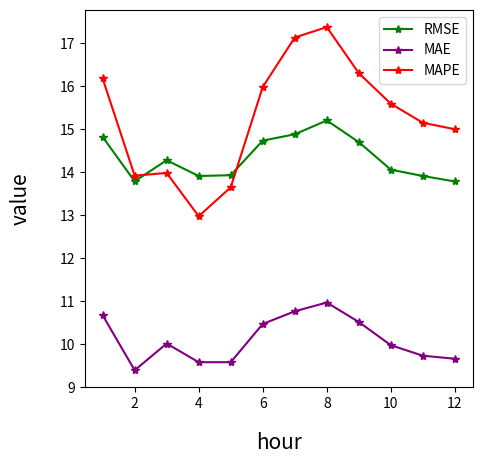

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] 
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=(5,5),dpi=100,linewidth = 2)
draw_data = np.array(xg_dataframe )

plt.plot(xg_dataframe.index,draw_data[:,1],'-*',color="green",label="RMSE")
plt.plot(xg_dataframe.index,draw_data[:,2],'-*',color='purple',label='MAE')
plt.plot(xg_dataframe.index,draw_data[:,3],'-*',color='red',label='MAPE')

plt.xlabel("hour", fontsize=15, labelpad = 15)

# 標示y軸(labelpad代表與圖片的距離)

plt.ylabel("value", fontsize=15, labelpad = 20)
#plt.xlabel("均價")
plt.legend()
plt.show()

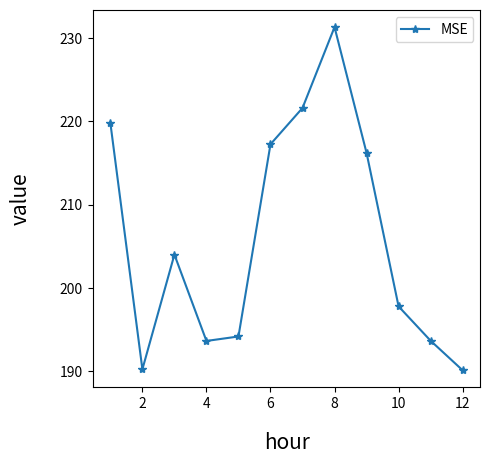

In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] 
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=(5,5),dpi=100,linewidth = 2)
draw_data = np.array(xg_dataframe )

plt.plot(xg_dataframe.index,draw_data[:,0],'-*',label="MSE")

plt.xlabel("hour", fontsize=15, labelpad = 15)

# 標示y軸(labelpad代表與圖片的距離)

plt.ylabel("value", fontsize=15, labelpad = 20)
#plt.xlabel("均價")
plt.legend()
plt.show()

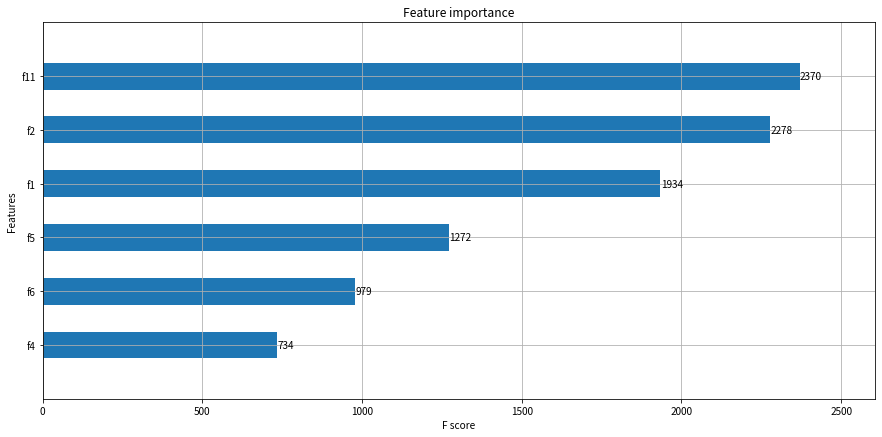

In [274]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] 
plt.rcParams['axes.unicode_minus']=False

plt.rcParams["figure.figsize"] = (13, 7)
fig=plot_importance(xgb,
                height=0.5,
                max_num_features=6).figure

fig.savefig('Feature重要度.png',dpi=200)
plt.title('Feature importance')
plt.tight_layout()
#fig.savefig('feture.png',dpi=200)

# LSTM

In [93]:
def buildTrain2(train, pastDay=10, futureDay=5):
    X_train, y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["people"]))
    return np.array(X_train), np.array(y_train)

In [94]:
lstm_df = pd.DataFrame()

In [95]:
def model_training_LSTM(hour):
    global get_lstm,lstm_df
    X_train, y_train = buildTrain2(df_train2, hour, 1)
    X_test, y_test = buildTrain2(df_test2, hour, 1)
    
    model = tensorflow.keras.Sequential()
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    model.add(LSTM(16, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.1))
    model.add(Dense(y_train.shape[1]))
    model.compile(loss='mae', optimizer=adam)
    
    start = time.time()
    hist = model.fit(X_train, y_train,batch_size=20,epochs=100)
    end = time.time()
    timespend = end-start
    
    testPredict_lstm = model.predict(X_test)
    test_y = pd.DataFrame(y_test,columns=['true'])
    test_y = denormalize2(test_y)
    test_y = test_y.reset_index(drop=True)
    test_predict = pd.DataFrame(testPredict_lstm ,columns=['predict'])
    test_predict  = denormalize2(test_predict)

    g1_test = pd.concat([test_y,test_predict], axis = 1)
    g1_test = g1_test[g1_test['true']!=0]
    
    MSE = metrics.mean_squared_error(test_y, test_predict)
    RMSE = np.sqrt(metrics.mean_squared_error(test_y,test_predict ))
    MAE = metrics.mean_absolute_error(test_y,test_predict)
    MAPE = mape(np.array(g1_test['true']), np.array(g1_test['predict']))
    R2 = r2_score(np.array(g1_test['true']),  np.array(g1_test['predict']))
    

    lstm_dataframe = pd.DataFrame({'MSE':MSE,
                            'RMSE':RMSE,
                            'MAE':MAE,
                            'MAPE':MAPE,
                            'R2':R2,
                            'Time':timespend},index=[1])
    lstm_df = pd.concat([lstm_df,lstm_dataframe])
    return lstm_df


In [96]:
for i in range(1,13):
    print(i)
    hour = i  
    lstm_dataframe = model_training_LSTM(hour)
    print('------------------------')

1
Epoch 1/100
293/293 [==============================] - 1s 1ms/step - loss: 0.1581
Epoch 2/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0661
Epoch 3/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0607
Epoch 4/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0595
Epoch 5/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0574
Epoch 6/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0582
Epoch 7/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0557
Epoch 8/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0534
Epoch 9/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0565
Epoch 10/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0567
Epoch 11/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0557
Epoch 12/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0546
Epoch 13/10

293/293 [==============================] - 0s 1ms/step - loss: 0.0454
Epoch 100/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0466
------------------------
2
Epoch 1/100
293/293 [==============================] - 1s 2ms/step - loss: 0.1525
Epoch 2/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0740
Epoch 3/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0650
Epoch 4/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0608
Epoch 5/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0561
Epoch 6/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0550
Epoch 7/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0533
Epoch 8/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0527
Epoch 9/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0516
Epoch 10/100
293/293 [==============================] - 0s 1ms/step - loss: 0.049

293/293 [==============================] - 0s 1ms/step - loss: 0.0377
Epoch 98/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0365
Epoch 99/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0390
Epoch 100/100
293/293 [==============================] - 0s 1ms/step - loss: 0.0372
------------------------
3
Epoch 1/100
293/293 [==============================] - 1s 2ms/step - loss: 0.1240
Epoch 2/100
293/293 [==============================] - 0s 2ms/step - loss: 0.0722
Epoch 3/100
293/293 [==============================] - 0s 2ms/step - loss: 0.0643
Epoch 4/100
293/293 [==============================] - 0s 2ms/step - loss: 0.0614
Epoch 5/100
293/293 [==============================] - 0s 2ms/step - loss: 0.0572
Epoch 6/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0566
Epoch 7/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0545
Epoch 8/100
293/293 [==============================] - 0s 2ms/step - loss: 0.05

293/293 [==============================] - 0s 2ms/step - loss: 0.0385
Epoch 96/100
293/293 [==============================] - 0s 2ms/step - loss: 0.0376
Epoch 97/100
293/293 [==============================] - 0s 2ms/step - loss: 0.0369
Epoch 98/100
293/293 [==============================] - 0s 2ms/step - loss: 0.0393
Epoch 99/100
293/293 [==============================] - 0s 2ms/step - loss: 0.0384
Epoch 100/100
293/293 [==============================] - 0s 2ms/step - loss: 0.0375
------------------------
4
Epoch 1/100
293/293 [==============================] - 1s 2ms/step - loss: 0.1427
Epoch 2/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0779
Epoch 3/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0674
Epoch 4/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0643
Epoch 5/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0607
Epoch 6/100
293/293 [==============================] - 1s 2ms/step - loss: 0.

293/293 [==============================] - 1s 2ms/step - loss: 0.0384
Epoch 94/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0369
Epoch 95/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0366
Epoch 96/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0368
Epoch 97/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0367
Epoch 98/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0379
Epoch 99/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0371
Epoch 100/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0369
------------------------
5
Epoch 1/100
293/293 [==============================] - 1s 2ms/step - loss: 0.1627
Epoch 2/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0808
Epoch 3/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0716
Epoch 4/100
293/293 [==============================] - 1s 2ms/step - loss: 

293/293 [==============================] - 1s 2ms/step - loss: 0.0394
Epoch 92/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0390
Epoch 93/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0386
Epoch 94/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0376
Epoch 95/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0394
Epoch 96/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0385
Epoch 97/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0376
Epoch 98/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0376
Epoch 99/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0383
Epoch 100/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0384
------------------------
6
Epoch 1/100
293/293 [==============================] - 2s 3ms/step - loss: 0.1410
Epoch 2/100
293/293 [==============================] - 1s 2ms/step - loss

293/293 [==============================] - 1s 2ms/step - loss: 0.0382
Epoch 90/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0363
Epoch 91/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0383
Epoch 92/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0372
Epoch 93/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0376
Epoch 94/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0377
Epoch 95/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0373
Epoch 96/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0369
Epoch 97/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0366
Epoch 98/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0376
Epoch 99/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0370
Epoch 100/100
293/293 [==============================] - 1s 2ms/step - loss: 0.0378
----------------

293/293 [==============================] - 1s 3ms/step - loss: 0.0371
Epoch 88/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0370
Epoch 89/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0373
Epoch 90/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0370
Epoch 91/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0364
Epoch 92/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0376
Epoch 93/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0348
Epoch 94/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0366
Epoch 95/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0376
Epoch 96/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0379
Epoch 97/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0364
Epoch 98/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0365
Epoch 99/100
293/

293/293 [==============================] - 1s 3ms/step - loss: 0.0356
Epoch 86/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0359
Epoch 87/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0365
Epoch 88/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0368
Epoch 89/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0363
Epoch 90/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0349
Epoch 91/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0360
Epoch 92/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0359
Epoch 93/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0376
Epoch 94/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0371
Epoch 95/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0362
Epoch 96/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0371
Epoch 97/100
293/

293/293 [==============================] - 1s 3ms/step - loss: 0.0385
Epoch 84/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0377
Epoch 85/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0380
Epoch 86/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0385
Epoch 87/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0380
Epoch 88/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0375
Epoch 89/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0367
Epoch 90/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0376
Epoch 91/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0382
Epoch 92/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0364
Epoch 93/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0377
Epoch 94/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0376
Epoch 95/100
293/

293/293 [==============================] - 1s 3ms/step - loss: 0.0371
Epoch 82/100
293/293 [==============================] - 1s 4ms/step - loss: 0.0360
Epoch 83/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0378
Epoch 84/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0367
Epoch 85/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0361
Epoch 86/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0368
Epoch 87/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0375
Epoch 88/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0373
Epoch 89/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0371
Epoch 90/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0367
Epoch 91/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0358
Epoch 92/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0370
Epoch 93/100
293/

293/293 [==============================] - 1s 3ms/step - loss: 0.0370
Epoch 80/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0363
Epoch 81/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0378
Epoch 82/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0361
Epoch 83/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0363
Epoch 84/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0367
Epoch 85/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0371
Epoch 86/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0362
Epoch 87/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0373
Epoch 88/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0365
Epoch 89/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0358
Epoch 90/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0365
Epoch 91/100
293/

293/293 [==============================] - 1s 4ms/step - loss: 0.0363
Epoch 78/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0380
Epoch 79/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0361
Epoch 80/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0373
Epoch 81/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0362
Epoch 82/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0366
Epoch 83/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0370
Epoch 84/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0365
Epoch 85/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0374
Epoch 86/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0361
Epoch 87/100
293/293 [==============================] - 1s 3ms/step - loss: 0.0364
Epoch 88/100
293/293 [==============================] - 1s 4ms/step - loss: 0.0366
Epoch 89/100
293/

In [205]:
lstm_dataframe =lstm_dataframe.reset_index(drop=True)

In [281]:
lstm_dataframe.index = lstm_dataframe.index+1

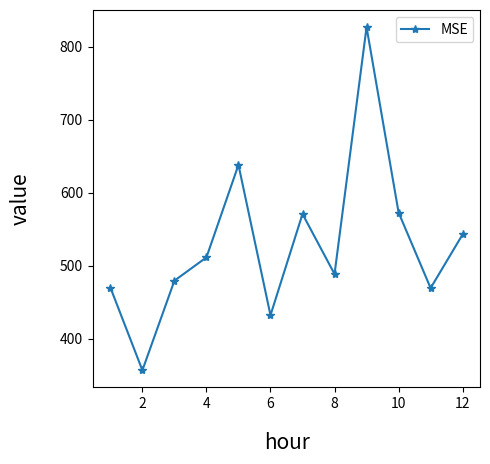

In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] 
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=(5,5),dpi=100,linewidth = 2)
draw_data = np.array(lstm_dataframe )

plt.plot(lstm_dataframe.index,draw_data[:,0],'-*',label="MSE")


plt.xlabel("hour", fontsize=15, labelpad = 15)

# 標示y軸(labelpad代表與圖片的距離)

plt.ylabel("value", fontsize=15, labelpad = 20)
#plt.xlabel("均價")
plt.legend()
plt.show()

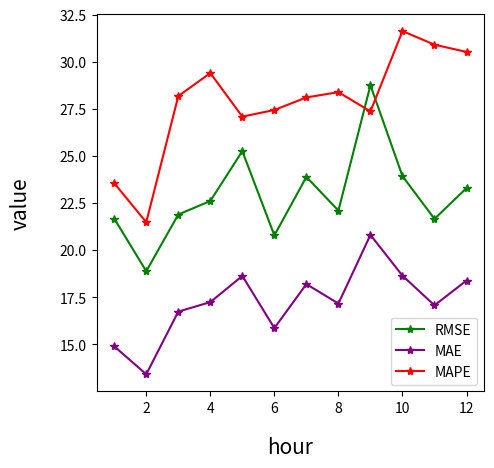

In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] 
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=(5,5),dpi=100,linewidth = 2)
draw_data = np.array(lstm_dataframe )

plt.plot(lstm_dataframe.index,draw_data[:,1],'-*',color="green",label="RMSE")
plt.plot(lstm_dataframe.index,draw_data[:,2],'-*',color='purple',label='MAE')
plt.plot(lstm_dataframe.index,draw_data[:,3],'-*',color='red',label='MAPE')

plt.xlabel("hour", fontsize=15, labelpad = 15)

# 標示y軸(labelpad代表與圖片的距離)

plt.ylabel("value", fontsize=15, labelpad = 20)
#plt.xlabel("均價")
plt.legend()
plt.show()

In [272]:
lstm_dataframe.to_csv('/Users/julia/Desktop/科技部大專生計畫/預測結果/五峰旗LSTM.csv')

In [196]:
def Saveplot(history):
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.plot(history.epoch, history.history['loss'], 'red', lw=2,  label = 'Training')
    #plt.plot(history.epoch, history.history['val_loss'], 'blue', lw=2, label = 'Validation')

    plt.legend()
    plt.show()
    #plt.savefig('路徑.png', dpi=100)

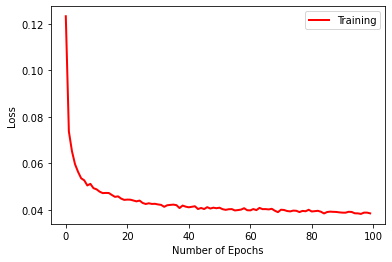

In [197]:
Saveplot(hist)